In [1]:
def getAlphaNodes(order):
    with open("alpha_nodes/nodes_"+str(order)+".txt") as nodes_file:
        nodes = nodes_file.read().split("\n")
        nodes = [node.split(" ") for node in nodes]
        nodes_float = []
        for node in nodes:
            node_float = []
            append=True
            for coord in node:
                try:
                    node_float.append(float(coord))
                except ValueError:
                    append=False
                    print("Ignoring :"+str(node))
            if append:
                nodes_float.append(node_float)
    return nodes_float

In [2]:
def generateAlphaWeights(basis):
    weights = [0.0]*len(basis)
    for i in range(len(basis)):
        weights[i] = integrate(integrate(basis[i],y,a=0,b=1.0-x),x,a=0.0,b=1.0)
    return weights
    
#weights = generateAlphaWeights(basis2D)
#with open("alpha_nodes/weights_"+str(order)+".txt","w") as weights_file:
#    weights_file.write("\n".join(list(map(str,weights))))

In [3]:
def vandermonde_2D(order,nodes):   
    xi = var("xi",domain=RR)
    eta = var("eta",domain=RR)
 
    r = var("r",domain=RR)
    p = var("p",domain=RR)
    s = var("s",domain=RR)
    
    x = var("x",domain=RR)
    y = var("y",domain=RR)

    #span jacobi basis
    basis_list = []

    for d in range(0,order+1):
        for j in range(0,d+1):
            i = d-j
            poly = simplify(jacobi_P(i,0,0,r) * jacobi_P(j,2*i+1,0,s) *((1.0-s)*(1.0/2.0))**i)
            poly = poly( r = 2.0 * y / p - 1.0 ).simplify_full()
            poly = poly( s = -2.0*p+1.0 ).simplify_full()
            poly = poly( p = (1.0 - x) )
            basis_list.append(poly)
            
    basis= Matrix(basis_list[::-1])
    vandermonde = Matrix( [[0.0] * len(nodes)] * len(nodes))
    for i in range(0,len(nodes)):
        for j in range(0,len(nodes)):
            eta_n = nodes[i][0]
            xi_n  = nodes[i][1]
            
            vandermonde[i,j] = simplify(basis[0][j](x=eta_n,y=xi_n))
    #print(vandermonde)
    vandermonde_inv = vandermonde.inverse()
    #print(vandermonde_inv)
    vandermonde_inv = [ [ entry if abs(entry) > 1.0e-15 else 0.0 for entry in row] for row in vandermonde_inv ]
    vandermonde_inv = matrix(vandermonde_inv)
    #print(vandermonde_inv)
    orthogonal_basis = simplify(basis * vandermonde_inv)
    return orthogonal_basis[0]
#basis2D = vandermonde_2D(order,alphaNodes)
#print(basis2D)

In [4]:
#from: http://mathworld.wolfram.com/LobattoQuadrature.html
def getGLLNodes(order):
    t = var("t",domain=RR)
    nodes = []
    if order > 1:
        print(derivative(gen_legendre_P(order,0,t),t))
        roots = np.roots(derivative(gen_legendre_P(order,0,t),t).coefficients(sparse=False)[::-1])
        #roots = simplify(derivative(gen_legendre_P(order,0,t),t).roots())
        nodes = [ node for node in roots if imag(node) == 0]
    nodes.extend([-1,1])
    nodes = sorted([ node/2.0 + 0.5 for node in nodes])
    #nodes = [node.numerical_approx() for node in nodes]
    return nodes

In [5]:
def getLagrangeBasis(nodes):
    basisTime = [0] * len(nodes)
    R = RR["t"]
    for i in range(0,len(nodes)):
        vals = [0] * len(nodes)
        vals[i] = 1
        tuples = zip(nodes, vals)

        basisTime[i] = R.lagrange_polynomial(tuples)
    return basisTime

In [6]:
def generate_dudx(basis,direction):
    N = len(basis)
    dudx = Matrix([0]*N)
    for i in range(N):
        for j in range(N):
            dudx[i] = derivative(basis[i],direction)
    return dudx

In [7]:
def numerical_integral_2d(func,a1=0,b1=1,a2=0,b2=1,c=-1):
    integrand = lambda x : numerical_integral(func,a2,b2+x*c,params=[x])[0]
    return numerical_integral(integrand,a1,b1)[0]

In [8]:
def generate_s_m(basis):
    x = var("x",domain=RR)
    y = var("y",domain=RR)

    N = len(basis)
    m = Matrix([[0.0]*N]*N)
    for i in range(N):
        for j in range(N):
            #m[i,j] = integrate(integrate(simplify(basis[i]*basis[j]),y,a=0,b=1.0-x),x,a=0.0,b=1.0)
            #print(i)
            #print(j)
            #print(basis[i])
            m[i,j] = numerical_integral_2d(simplify(basis[i]*basis[j]))
    return m
#s_m = generate_s_m(basis2D)

In [9]:
def generate_t_m(basis):
    t = var("t",domain=RR)
    N = len(basis)
    m = Matrix([[0.0]*N]*N)
    for i in range(N):
        for j in range(N):
            m[i,j] = integrate((basis[i]*basis[j])(t),t,0,1)
    return m

In [10]:
def generate_t_a(basis):
    t = var("t",domain=RR)
    N = len(basis)
    m = Matrix([[0.0]*N])
    for i in range(N):
            m[0,i] = integrate(basis[i](t),t,0,1)
    return m

In [11]:
def generate_t_k(basis):
    N = len(basis)
    m = Matrix(RR,[[0.0]*N]*N)
    for i in range(N):
        for j in range(N):
            m[i,j] = integrate(basis[i]*derivative(basis[j],t)(t),t,0,1)
    return m

In [12]:
def generate_s_b(basis,order,edge,sparse=True):
    N = len(basis)
    if sparse:
        cols = getDGIndeces(order,edge)
    else:
        cols = range(0,N)
        
    b = Matrix([[0.0]*len(cols)]*N)
    t = var("t",domain=RR)
    if edge == "l":
        path = [t,0]
    if edge == "r":
        path = [0,t]
    if edge == "m":
        path = [1-t,t]
    for i in range(N):
        for j in range(len(cols)):
            b[i,j] = numerical_integral(basis[i](x=path[0],y=path[1]) * basis[cols[j]](x=path[0],y=path[1]), 0 , 1)[0]           
    return b

In [16]:
def generate_s_k(basis,direction):
    N = len(basis)
    k = Matrix([[0.0]*N]*N)
    for i in range(N):
        for j in range(N):
            k[i,j] = numerical_integral_2d(basis[j] * derivative(basis[i],direction))
    return k

In [17]:
def generate_phi(basis,order,triangles):
    N   = len(basis)
    phi = Matrix([[0.0]*N]*len(triangles))
    num=2*order+1
    for n in range(0,N):

        ind = 0
        for i in range(0,num):
            for j in range(0,i+1):
                if not j == 0:
                    ind = ind + 2
                triangle = triangles[ind]
                phi[ind,n] = integral(integral(basis[n],y,a=triangle[0][1],b=triangle[2][1]-(x-triangle[0][0])),
                                                        x,a=triangle[0][0],b=triangle[1][0])
            ind = ind + 1    
            
        ind = 2
        for i in range(1,num):
            for j in range(1,i+1):
                if not j == 1:
                    ind = ind + 2
                triangle = triangles[ind]
                            #triangles[ind] = [nodes_top[j], nodes_top[j-1], nodes_bottom[j]]
                phi[ind,n] = integral(integral(basis[n],x,a=triangle[0][0]-(y-triangle[2][1]),b=triangle[2][0]),
                                                        y,a=triangle[1][1],b=triangle[2][1])
            ind = ind + 3     

    return phi

In [18]:
def generate_mue(basis,order,phi):
    N = (order+1)*(order+2)//2
    N_mue = N + 1
    mue = matrix([[0.0]*N_mue]* N_mue)
    #print(phi.transpose()* phi)
    mue[:N,:N] = 2.0 * phi.transpose()* phi            
    for i in range(0,N):
        mue[N_mue-1,i] = numerical_integral_2d(basis[i])
        mue[i,N_mue-1] = mue[N_mue-1,i]
    return mue.inverse()

In [19]:
def printMatrix(matrix,name,order):
    dimString = dimMapping[matrix.nrows()]+","+dimMapping[matrix.ncols()]
    matrix_name = name+"("+dimString+")"
    output_string="real(kind=GRID_SR),Parameter :: "+matrix_name+" = reshape((/ &\n"
    for j in range(matrix.ncols()):
        for i in range(matrix.nrows()):
            #if i != 0 and i % 10 == 0:
            #        output_string = output_string + "&\n"
            output_string = output_string + str(matrix[i,j]) + "_GRID_SR ,"
        output_string = output_string + "&\n"
    #remove last seperator
    output_string = output_string[:-3]
    output_string = output_string + "  /),(/"+dimString+"/))"
    with open(str(name)+"_"+str(order)+".incl","w") as output:
        output.write(output_string)

In [20]:
def printVector(vector,name,order):
    dimString = dimMapping[vector.degree()]
    vector_name = name+"("+dimString+")"
    output_string="real(kind=GRID_SR),Parameter :: "+vector_name+" = (/ &\n"
    for i in range(vector.degree()):
            #if i != 0 and i % 10 == 0:
            #        output_string = output_string + "&\n"
        output_string = output_string + str(vector[i]) + "_GRID_SR ,"
    output_string = output_string + "&\n"
    #remove last seperator
    output_string = output_string[:-3]
    output_string = output_string + "  /)"
    with open(str(name)+"_"+str(order)+".incl","w") as output:
        output.write(output_string)


In [21]:
import matplotlib.pyplot as plt
def generatePatch(order,show):
    num = 2*order+1
    nodes = []
    for i in range(0,num+1):
        nodes.append([])
        for j in range(0,i+1):
            nodes[i].append([(i-j)/float(num),j/float(num)])
    triangles = [[[0,0],[0,0],[0,0]]] * num * num
    
    ind = 0
    for i in range(0,num):
        nodes_top    = nodes[i]
        nodes_bottom = nodes[i+1]
        for j in range(0,i+1):
            if not j == 0:
                ind = ind + 2
            triangles[ind] = [nodes_top[j], nodes_bottom[j], nodes_bottom[j+1]]
        ind = ind + 1    
            
    ind = 2
    for i in range(1,num):
        nodes_top    = nodes[i]
        nodes_bottom = nodes[i+1]
        for j in range(1,i+1):
            if not j == 1:
                ind = ind + 2
            triangles[ind] = [nodes_top[j], nodes_top[j-1], nodes_bottom[j]]
        ind = ind + 3         
    i = 0
    if show:
        for triangle in triangles:
            plt.plot([triangle[0][0], triangle[1][0], triangle[2][0], triangle[0][0]],
                    [triangle[0][1], triangle[1][1], triangle[2][1], triangle[0][1]])
            center_x = (triangle[0][0]+ triangle[1][0] + triangle[2][0])/3.0
            center_y = (triangle[0][1]+ triangle[1][1] + triangle[2][1])/3.0
            plt.text(center_x,center_y,str(i))
            i = i + 1 

        plt.show()
    return triangles

In [22]:
def generate_ref(basis,side):
    #s_m = generate_s_m(basis)
    if(side == "l"):   #ref1
        trafo = [- 0.5 * x - 0.5 * y + 0.5,
                   0.5 * x - 0.5 * y + 0.5]
    elif(side == "r"): #ref2
        trafo = [- 0.5 * x + 0.5 * y + 0.5,
                 - 0.5 * x - 0.5 * y + 0.5]
    basis_trafo = [b(x=trafo[0], y=trafo[1]) for b in basis]
    N = len(basis)

    s_m_trafo = Matrix([[0.0]*N]*N)
    for i in range(N):
        for j in range(N):
            s_m_trafo[i,j] = numerical_integral_2d(simplify(basis[i]*basis_trafo[j]))
    return s_m_trafo

In [23]:
def generate_coarse(basis,side):
    #s_m = generate_s_m(basis)
    if(side == "l"):   #L
        trafo_a = [-(x - 0.5) + (y - 0.5),
                   -(x - 0.5) - (y - 0.5)]
        trafo_b = [x,y]
    elif(side == "r"): #R
        trafo_a = [-(y - 0.5) - (x - 0.5),
                   +(y - 0.5) - (x - 0.5)]
        trafo_b = [y,x]

    basis_trafo_a = [b(x=trafo_a[0], y=trafo_a[1]) for b in basis]
    basis_trafo_b = [b(x=trafo_b[0], y=trafo_b[1]) for b in basis]

    N = len(basis)

    s_m_trafo = Matrix([[0.0]*N]*N)
    for i in range(N):
        for j in range(N):
            s_m_trafo[i,j]   = numerical_integral_2d(simplify(basis_trafo_b[i]*basis_trafo_a[j]),0,0.5,0,0,1) +\
                               numerical_integral_2d(simplify(basis_trafo_b[i]*basis_trafo_a[j]),0.5,1,0,1,-1)
            #s_m_trafo[i,j+N] = numerical_integral_2d(simplify(basis[i]*basis_trafo[j]),0,0.5,0,0,1) + 
            #                   numerical_integral_2d(simplify(basis[i]*basis_trafo[j]),0.5,1,0,1,-1)

    return s_m_trafo

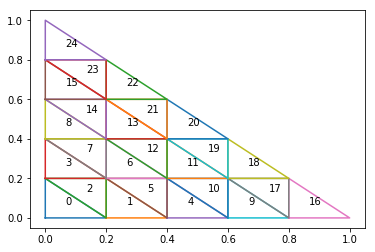

[[[0.0, 0.0], [0.2, 0.0], [0.0, 0.2]],
 [[0.2, 0.0], [0.4, 0.0], [0.2, 0.2]],
 [[0.0, 0.2], [0.2, 0.0], [0.2, 0.2]],
 [[0.0, 0.2], [0.2, 0.2], [0.0, 0.4]],
 [[0.4, 0.0], [0.6, 0.0], [0.4, 0.2]],
 [[0.2, 0.2], [0.4, 0.0], [0.4, 0.2]],
 [[0.2, 0.2], [0.4, 0.2], [0.2, 0.4]],
 [[0.0, 0.4], [0.2, 0.2], [0.2, 0.4]],
 [[0.0, 0.4], [0.2, 0.4], [0.0, 0.6]],
 [[0.6, 0.0], [0.8, 0.0], [0.6, 0.2]],
 [[0.4, 0.2], [0.6, 0.0], [0.6, 0.2]],
 [[0.4, 0.2], [0.6, 0.2], [0.4, 0.4]],
 [[0.2, 0.4], [0.4, 0.2], [0.4, 0.4]],
 [[0.2, 0.4], [0.4, 0.4], [0.2, 0.6]],
 [[0.0, 0.6], [0.2, 0.4], [0.2, 0.6]],
 [[0.0, 0.6], [0.2, 0.6], [0.0, 0.8]],
 [[0.8, 0.0], [1.0, 0.0], [0.8, 0.2]],
 [[0.6, 0.2], [0.8, 0.0], [0.8, 0.2]],
 [[0.6, 0.2], [0.8, 0.2], [0.6, 0.4]],
 [[0.4, 0.4], [0.6, 0.2], [0.6, 0.4]],
 [[0.4, 0.4], [0.6, 0.4], [0.4, 0.6]],
 [[0.2, 0.6], [0.4, 0.4], [0.4, 0.6]],
 [[0.2, 0.6], [0.4, 0.6], [0.2, 0.8]],
 [[0.0, 0.8], [0.2, 0.6], [0.2, 0.8]],
 [[0.0, 0.8], [0.2, 0.8], [0.0, 1.0]]]

In [24]:
generatePatch(2,show=True)

In [25]:
import matplotlib.pyplot as plt
def getFVEdgeIndeces(order,edge):
    indeces = []
    num = 2 * order + 2 
    if edge == "l":
        for i in range(2*order,-1,-1):
            indeces.append(i*i)
    if edge == "m":
        for i in range(2*order,-1,-1):
            indeces.append((2 * order + 1) **2 - (2 * order + 1) - (2 * order ) + 1 * i * 2)
    if edge == "r":
        for i in range(0,2*order+1):
            indeces.append((i+1)*(i+1)-1)
    return indeces
getFVEdgeIndeces(3,"r")

[0, 3, 8, 15, 24, 35, 48]

In [26]:
def getDGIndeces(order,direction):
    indeces=[]
    if direction == "l":
        return list(range(0,order + 1))
    if direction == "m":
        idx=order
        for i in range(0,order + 1):
            indeces.append(idx)
            idx = idx + order - i
    if direction == "r":
        idx=0
        for i in range(0,order + 1):
            indeces.append(idx)
            idx = idx + order + 1 - i
    return indeces    

In [27]:
def functionToFrotranString(expr,i):
    basis_name = "basis_"+str(i)
    results_str  ="function "+basis_name+"(x,y)\n"
    results_str +="  real(kind = GRID_SR) ::"+basis_name +"\n"
    results_str +="  real(kind = GRID_SR),intent(in) :: x\n"
    results_str +="  real(kind = GRID_SR),intent(in) :: y\n"
    results_str +="  "+basis_name+" = "

    for coeff_y, exp_y in expr.coefficients(y):
        if exp_y != 0:
            results_str += "y**"+str(exp_y) + " * "
        results_str += "("
        for coeff_x, exp_x in coeff_y.coefficients(x):
            if exp_x != 0:
                results_str += "x**"+str(exp_x)
                results_str += " * "
            results_str += str(coeff_x)+"_GRID_SR + "
        results_str = results_str[:-3] # remove last + for x coeff

        results_str += ") + "
    results_str  = results_str[:-3] # remove last + for y coeff
    results_str +="\nend function "+basis_name

    return results_str

In [28]:
def printBasisFunctions(basis2D,order):
    basis_functions_string = ""
    for basis_idx in range(0,len(basis2D)):
        expr=basis2D[basis_idx]
        basis_functions_string += functionToFrotranString(expr,basis_idx+1)
        basis_functions_string += "\n \n"

    basis_functions_string +=\
"""function evaluate(Q,coords)
  real(kind = GRID_SR)            :: evaluate
  real(kind = GRID_SR),intent(in) :: Q(_SWE_DG_DOFS)
  real(kind = GRID_SR),intent(in) :: coords(2) 

  evaluate =&
  """
    for basis_idx in range(0,len(basis2D)):
        basis_functions_string += "basis_"+str(basis_idx+1)+"(coords(1),coords(2))"
        basis_functions_string += " * Q("+str(basis_idx+1)+") +&"
        basis_functions_string +="\n  "
    
    basis_functions_string = basis_functions_string[:-6]
    basis_functions_string += "\nend function evaluate" 

    with open("basis_"+str(order)+".incl","w") as output:
        output.write(basis_functions_string)

In [29]:
import numpy as np
order = 2
dimMapping = { 1:"1", order:"_SWE_DG_ORDER" , order+1:"_SWE_DG_ORDER+1" , (order+1)*(order+2)/2 : "_SWE_DG_DOFS"}
gllNodes  = getGLLNodes(order)
timeBasis = getLagrangeBasis(gllNodes)


dimMapping = { 1                      : str(1), 
               2                      : str(2), 
              order                   : str(order) ,
              order+1                 : str(order+1) ,
              (order+1)*(order+2)/2   : str((order+1)*(order+2)/2),
              (order+1)*(order+2)/2+1 : str((order+1)*(order+2)/2+1),
              (order+1)*(order+2)     : str((order+1)*(order+2)),
              (2*order+1)             : str((2*order+1)),
              (2*order+1)**2          : str((2*order+1)**2)}


alphaNodes = getAlphaNodes(order)
basis2D = vandermonde_2D(order,alphaNodes)
printBasisFunctions(basis2D,order)


3*t
Ignoring :['']


In [30]:
t_m = generate_t_m(timeBasis)
t_m_1 = t_m[1:,:]

t_k_t        = generate_t_k(timeBasis)
t_k_t_10     = matrix(t_k_t[1:,:1])
t_k_t_11     = matrix(t_k_t[1:,1:])
t_k_t_11_inv = matrix(np.linalg.inv(t_k_t_11))

t_a = generate_t_a(timeBasis)

printMatrix(t_m_1,"t_m_1",order)
printMatrix(t_a  ,"t_a"  ,order)
#printMatrix(t_k_t,"t_k_t",order)
printMatrix(t_k_t_10    ,"t_k_t_10",order)
printMatrix(t_k_t_11_inv,"t_k_t_11_inv",order)

In [31]:
#order = 3
#dimMapping = { 1                    : "1", 
#              order                 : "_SWE_DG_ORDER" ,
#              order+1               : "_SWE_DG_ORDER+1" ,
#              (order+1)*(order+2)/2 : "_SWE_DG_DOFS",
#              (2*order+1)           : "_SWE_PATCH_ORDER",
#              (2*order+1)**2        : "_SWE_PATCH_ORDER * _SWE_PATCH_ORDER"}

weights = alphaWeights = generateAlphaWeights(basis2D)
with open("alpha_nodes/weights_"+str(order)+".txt","w") as weights_file:
    weights_file.write("\n".join(list(map(str,weights))))

s_m = generate_s_m(basis2D)
s_k_x = generate_s_k(basis2D,x)
s_k_y = generate_s_k(basis2D,y)

printMatrix(s_m  ,"s_m"  ,order)
printMatrix(s_m.inverse() ,"s_m_inv"  ,order)

printMatrix(s_k_x,"s_k_x",order)
printMatrix(s_k_y,"s_k_y",order)

In [32]:
s_b_1_l = generate_s_b(basis2D,order,"l")
s_b_3_r = generate_s_b(basis2D,order,"r")
s_b_2_m = generate_s_b(basis2D,order,"m")

printMatrix(s_b_1_l,"s_b_1_l",order)
printMatrix(s_b_2_m,"s_b_2_m",order)
printMatrix(s_b_3_r,"s_b_3_r",order)

s_b_1 = generate_s_b(basis2D,order,"l",sparse=False)
s_b_3 = generate_s_b(basis2D,order,"r",sparse=False)
s_b_2 = generate_s_b(basis2D,order,"m",sparse=False)

printMatrix(s_b_1,"s_b_1",order)
printMatrix(s_b_2,"s_b_2",order)
printMatrix(s_b_3,"s_b_3",order)

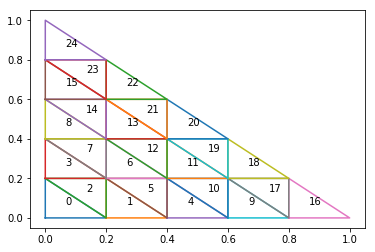

RuntimeError: ECL says: Console interrupt.

In [33]:
triangles=generatePatch(order,True)
phi = generate_phi(basis2D,order,triangles)
mue_inv = generate_mue(basis2D,order,phi)
printMatrix(phi,"phi",order)
printMatrix(mue_inv,"mue_inv",order)


phi_l = phi[getFVEdgeIndeces(order,"l"),:]
phi_r = phi[getFVEdgeIndeces(order,"r"),:]
phi_m = phi[getFVEdgeIndeces(order,"m"),:]

printMatrix(phi_l,"phi_l",order)
printMatrix(phi_r,"phi_r",order)
printMatrix(phi_m,"phi_m",order)

In [ ]:
mirrored_coordinates=vector([0]*len(basis2D))
ind = 0
for j in range(0,order+1):
    for i in range(0,order+1 - j):
        mirrored_coordinates[ind] = (order +1)*(order+2)/2 - (order +1-i)*(order+2-i)/2 +1 +j 
        ind = ind+1
printVector(mirrored_coordinates,"mirrored_coords",order)   
printMatrix(transpose(matrix(alphaNodes)),"nodes",order)

In [ ]:
ref1 = generate_ref(basis2D,"l")
ref2 = generate_ref(basis2D,"r")
coarse1 = generate_coarse(basis2D,"l")
coarse2 = generate_coarse(basis2D,"r")

coarse=matrix([[0.0]*coarse1.ncols()*2]*coarse2.nrows())
coarse[:,:coarse1.ncols()] = coarse1[:,:]
coarse[:,coarse1.ncols():] = coarse2[:,:]

printMatrix(ref1,"ref1",order)
printMatrix(ref1,"ref2",order)
printMatrix(coarse,"coarsen",order)

In [ ]:
basis_der_x = matrix([[0.0]*len(basis2D)]*len(alphaNodes))
basis_der_y = matrix([[0.0]*len(basis2D)]*len(alphaNodes))

for j in range(len(alphaNodes)):
    for i in range(len(basis2D)):
        basis_der_x[j,i] = derivative(basis2D[i],x)(x=alphaNodes[j][0],y=alphaNodes[j][1])
        basis_der_y[j,i] = derivative(basis2D[i],y)(x=alphaNodes[j][0],y=alphaNodes[j][1])

printMatrix(basis_der_x,"basis_der_x",order)
printMatrix(basis_der_y,"basis_der_y",order)

In [ ]:
import numpy as np
for order in range(1,10):
    print(order)
    dimMapping = { 1:"1", order:"_SWE_DG_ORDER" , order+1:"_SWE_DG_ORDER+1" , (order+1)*(order+2)/2 : "_SWE_DG_DOFS"}
    gllNodes  = getGLLNodes(order)
    timeBasis = getLagrangeBasis(gllNodes)


    dimMapping = { 1                      : str(1), 
                   2                      : str(2), 
                  order                   : str(order) ,
                  order+1                 : str(order+1) ,
                  (order+1)*(order+2)/2   : str((order+1)*(order+2)/2),
                  (order+1)*(order+2)/2+1 : str((order+1)*(order+2)/2+1),
                  (order+1)*(order+2)     : str((order+1)*(order+2)),
                  (2*order+1)             : str((2*order+1)),
                  (2*order+1)**2          : str((2*order+1)**2)}


    alphaNodes = getAlphaNodes(order)
    basis2D = vandermonde_2D(order,alphaNodes)
    t_m = generate_t_m(timeBasis)
    t_m_1 = t_m[1:,:]

    t_k_t        = generate_t_k(timeBasis)
    t_k_t_10     = matrix(t_k_t[1:,:1])
    t_k_t_11     = matrix(t_k_t[1:,1:])
    t_k_t_11_inv = matrix(np.linalg.inv(t_k_t_11))

    t_a = generate_t_a(timeBasis)

    printMatrix(t_m_1,"t_m_1",order)
    printMatrix(t_a  ,"t_a"  ,order)
    printMatrix(t_k_t,"t_k_t",order)
    printMatrix(t_k_t_10    ,"t_k_t_10",order)
    printMatrix(t_k_t_11_inv,"t_k_t_11_inv",order)
    
    
    weights = alphaWeights = generateAlphaWeights(basis2D)
    with open("alpha_nodes/weights_"+str(order)+".txt","w") as weights_file:
        weights_file.write("\n".join(list(map(str,weights))))

    s_m = generate_s_m(basis2D)
    s_k_x = generate_s_k(basis2D,x)
    s_k_y = generate_s_k(basis2D,y)

    printMatrix(s_m  ,"s_m"  ,order)
    printMatrix(s_m.inverse() ,"s_m_inv"  ,order)
    printMatrix(s_k_x,"s_k_x",order)
    printMatrix(s_k_y,"s_k_y",order)
    
    s_b_1_l = generate_s_b(basis2D,order,"l")
    s_b_3_r = generate_s_b(basis2D,order,"r")
    s_b_2_m = generate_s_b(basis2D,order,"m")

    printMatrix(s_b_1_l,"s_b_1_l",order)
    printMatrix(s_b_2_m,"s_b_2_m",order)
    printMatrix(s_b_3_r,"s_b_3_r",order)

    s_b_1 = generate_s_b(basis2D,order,"l",sparse=False)
    s_b_3 = generate_s_b(basis2D,order,"r",sparse=False)
    s_b_2 = generate_s_b(basis2D,order,"m",sparse=False)

    printMatrix(s_b_1,"s_b_1",order)
    printMatrix(s_b_2,"s_b_2",order)
    printMatrix(s_b_3,"s_b_3",order)
    
    triangles=generatePatch(order,True)
    phi = generate_phi(basis2D,order,triangles)
    mue_inv = generate_mue(basis2D,order,phi)
    printMatrix(phi,"phi",order)
    printMatrix(mue_inv,"mue_inv",order)


    phi_l = phi[getFVEdgeIndeces(order,"l"),:]
    phi_r = phi[getFVEdgeIndeces(order,"r"),:]
    phi_m = phi[getFVEdgeIndeces(order,"m"),:]

    printMatrix(phi_l,"phi_l",order)
    printMatrix(phi_r,"phi_r",order)
    printMatrix(phi_m,"phi_m",order)
    
    mirrored_coordinates=vector([0]*len(basis2D))
    ind = 0
    for j in range(0,order+1):
        for i in range(0,order+1 - j):
            mirrored_coordinates[ind] = (order +1)*(order+2)/2 - (order +1-i)*(order+2-i)/2 +1 +j 
            ind = ind+1
    printVector(mirrored_coordinates,"mirrored_coords",order)   
    printMatrix(transpose(matrix(alphaNodes)),"nodes",order)
        
    basis_der_x = matrix([[0.0]*len(basis2D)]*len(alphaNodes))
    basis_der_y = matrix([[0.0]*len(basis2D)]*len(alphaNodes))

    for j in range(len(alphaNodes)):
        for i in range(len(basis2D)):
            basis_der_x[j,i] = derivative(basis2D[i],x)(x=alphaNodes[j][0],y=alphaNodes[j][1])
            basis_der_y[j,i] = derivative(basis2D[i],y)(x=alphaNodes[j][0],y=alphaNodes[j][1])

    printMatrix(basis_der_x,"basis_der_x",order)
    printMatrix(basis_der_y,"basis_der_y",order)
    
    #ref1 = generate_ref(basis2D,"l")
    #ref2 = generate_ref(basis2D,"r")
    #coarse1 = generate_coarse(basis2D,"l")
    #coarse2 = generate_coarse(basis2D,"r")

    #coarse=matrix([[0.0]*coarse1.ncols()*2]*coarse2.nrows())
    #coarse[:,:coarse1.ncols()] = coarse1[:,:]
    #coarse[:,coarse1.ncols():] = coarse2[:,:]
    #printMatrix(ref1,"ref1",order)
    #printMatrix(ref1,"ref2",order)
    #printMatrix(coarse,"coarsen",order)

In [ ]:
import numpy as np
for order in range(8,10):
    print(order)

    dimMapping = { 1                      : str(1), 
                   2                      : str(2), 
                  order                   : str(order) ,
                  order+1                 : str(order+1) ,
                  (order+1)*(order+2)/2   : str((order+1)*(order+2)/2),
                  (order+1)*(order+2)/2+1 : str((order+1)*(order+2)/2+1),
                  (order+1)*(order+2)     : str((order+1)*(order+2)),
                  (2*order+1)             : str((2*order+1)),
                  (2*order+1)**2          : str((2*order+1)**2)}


    alphaNodes = getAlphaNodes(order)
    basis2D = vandermonde_2D(order,alphaNodes)
    #printBasisFunctions(basis2D,order)

    ref1 = generate_ref(basis2D,"l")
    ref2 = generate_ref(basis2D,"r")
    coarse1 = generate_coarse(basis2D,"l")
    coarse2 = generate_coarse(basis2D,"r")

    printMatrix(ref1,"ref1",order)
    printMatrix(ref2,"ref2",order)
    printMatrix(coarse1,"coarsen1",order)
    printMatrix(coarse2,"coarsen2",order)

# Generate Yateto Tensors

In [56]:
def getJacobian(i):
    angle = pi/4.0 * (i+1)
    return Matrix([[cos(angle),sin(angle)],[-sin(angle),cos(angle)]]).numerical_approx(digits=20)

def getJacobianPad(i):
    jac = getJacobian(i)
    return Matrix([[0,0],[jac[0,0],jac[1,0]],[jac[0,1],jac[1,1]]]).numerical_approx(digits=20)

In [57]:
def getJSONFormat(matrix,name):
    epsilon=10.0e-15
    string="{\n"
    string+='  "name": "{}",\n'.format(name)
    string+='  "rows":  {},\n'.format(len(matrix.rows()))
    string+='  "columns": {},\n'.format(len(matrix.columns()))
    string+='  "entries": ['
    for row in range(0,len(matrix.rows())):
        if (abs(matrix[row,:].numpy()) > epsilon).any():
            for column in range(0,len(matrix.columns())):
                entry=matrix[row,column]
                if(abs(entry) > epsilon):
                    string+= '[{}, {}, "{}"],'.format(row+1,column+1,entry)
    string=string[:-1]#remove last comma
    string+=']\n'
    string+="}\n"
    return string

In [58]:
def getTensorShape(tensor,rank):
    shape=()
    tensor_slice=tensor
    for i in range(rank):
        shape= shape[0:i+1] + (len(tensor_slice),)
        tensor_slice=tensor_slice[0]
    return shape

def getJSONFormatTensor(tensor,rank,name):
    epsilon=10.0e-15
    shape = list(getTensorShape(tensor,rank))
    num_entries = 1
    #span index space
    indeces = [(index,) for index in range(0,shape[0])]
    for shape_range in shape[1:]:
        new_indeces=[]
        for index in indeces:
            for new_index in range(0,shape_range):
                new_indeces += [index + (new_index,)]
        indeces=new_indeces
        #print(indeces)
    
    string="{\n"
    string+='  "name": "{}",\n'.format(name)
    string+='  "rank":  {},\n' .format(rank)
    string+='  "shape": {} ,\n'.format(shape)
    string+='  "entries": ['
    for index in indeces:
        entry=tensor[index[0]]
        for i in range(1,len(index)):
            entry=entry[index[i]]
        if(abs(entry)>epsilon):
            string += "["
            for i in range(0,len(index)):
                string += '{}, '.format(index[i]+1) 
            string += '"{}"'.format(entry)
            string += "],"

        #string+= '{}, {}, "{}"'.format(row+1,column+1,entry)
    #        string+=']'
    string=string[:-1]#remove last comma
    string+=']\n'
    string+="}"
    return string

In [ ]:
import numpy as np
orders=range(5,8)
for order in orders:
    alphaNodes = getAlphaNodes(order)
    basis2D    = vandermonde_2D(order,alphaNodes)
    gllNodes   = getGLLNodes(order)
    timeBasis  = getLagrangeBasis(gllNodes)


    t_m = generate_t_m(timeBasis)
    t_m_1 = t_m[1:,:]

    t_k_t        = generate_t_k(timeBasis)
    t_k_t_10     = matrix(t_k_t[1:,:1])
    t_k_t_11     = matrix(t_k_t[1:,1:])
    t_k_t_11_inv = matrix(np.linalg.inv(t_k_t_11))
    t_k_t_11_inv_t_m_1      = t_k_t_11_inv * t_m_1
    t_k_t_11_inv_x_t_k_t_10 = t_k_t_11_inv * t_k_t_10


    matrix_string="[\n"
    matrix_string+=getJSONFormat(t_k_t_11_inv_t_m_1,"t_k_t_11_inv_t_m_1")
    matrix_string += ","
    matrix_string+=getJSONFormat(t_k_t_11_inv_x_t_k_t_10,"t_k_t_11_inv_x_t_k_t_10")
    matrix_string += ","
    for i in range(0,8):
        matrix_string += getJSONFormat(getJacobianPad(i),"J({})".format(i))
        matrix_string += ","
    matrix_string = matrix_string[:-1]
    matrix_string+="]"

    with open("matrices_{}.json".format(order),"w") as file:
        file.write(matrix_string)
    
    s_m = generate_s_m(basis2D)
    s_k_x = generate_s_k(basis2D,x)
    s_k_y = generate_s_k(basis2D,y)

    s_m_inv_s_k_x_t = s_m.inverse()*s_k_x.transpose()
    s_m_inv_s_k_y_t = s_m.inverse()*s_k_y.transpose()
    s_m_inv_s_k = np.array([[[0.0]*len(s_m_inv_s_k_x_t.columns())]*2]*len(s_m_inv_s_k_x_t.rows()))
    s_m_inv_s_k[:,0,:] = s_m_inv_s_k_x_t
    s_m_inv_s_k[:,1,:] = s_m_inv_s_k_y_t
    s_m_inv_s_k_J_inv = []

    for i in range(0,8):
        jac_inv = getJacobian(i).inverse()
        s_m_inv_s_k_J_inv_i = np.zeros(s_m_inv_s_k.shape)
        s_m_inv_s_k_J_inv_i[:,0,:] = jac_inv[0,0] * s_m_inv_s_k[:,0,:] +\
                                     jac_inv[0,1] * s_m_inv_s_k[:,1,:]
        
        s_m_inv_s_k_J_inv_i[:,1,:] = jac_inv[1,0] * s_m_inv_s_k[:,0,:] +\
                                     jac_inv[1,1] * s_m_inv_s_k[:,1,:]
    
        s_m_inv_s_k_J_inv += [s_m_inv_s_k_J_inv_i]

    tensor_string="[\n"
    for i in range(0,8):
        tensor_string+= getJSONFormatTensor(s_m_inv_s_k_J_inv[i],3,"s_m_inv_s_k_J_inv({})".format(i))
        tensor_string+=",\n"
    
    Dx = np.array([[[0.0]*2]*len(basis2D)]*len(alphaNodes))

    for j in range(len(alphaNodes)):
            for i in range(len(basis2D)):
                Dx[i,j,0] = derivative(basis2D[i],x)(x=alphaNodes[j][0],y=alphaNodes[j][1])
                Dx[i,j,1] = derivative(basis2D[i],y)(x=alphaNodes[j][0],y=alphaNodes[j][1])

    tensor_string+=getJSONFormatTensor(Dx,3,"Dx")
    
    #tensor_string=tensor_string[:-2]# remove last new line and comma
    tensor_string+="\n]"

    with open("tensor_{}.json".format(order),"w") as file:
        file.write(tensor_string)

Ignoring :['']
315/8*t^4 - 105/4*t^2 + 15/8
